<a href="https://colab.research.google.com/github/specM7/DSGP_Group_33_Brain_Tumor_Predictor/blob/Meningioma_Adrian_2425482/Meningioma_Adrian_2425482.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  AI-Powered Brain Tumor Predictor for Meningioma(Adrian)


## Project Goal
Build a Convolutional Neural Network (CNN) to classify brain MRI images into 4 tumor categories.


## Model Specifications
- **Input**: 224x224 grayscale MRI images
- **Architecture**: Custom CNN with 3 convolutional blocks
- **Output**: 4-class classification (tumor types)
- **Training**: 25 epochs with validation split

##  Project Overview

This project uses a Convolutional Neural Network (CNN) to classify brain MRI images into four tumor categories:
- Glioma
- Meningioma
- Pituitary
- No Tumor

###  Objectives
- Build a robust CNN for MRI classification
- Achieve >90% accuracy on unseen test data
- Provide interpretable visual results


##  Technologies Used
- TensorFlow / Keras
- OpenCV
- NumPy
- Matplotlib & Seaborn


In [2]:
import os, glob, cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


##  Dataset Upload

Upload the `DataSet.zip` file containing MRI images organized into training and testing folders.


In [3]:
from google.colab import files

uploaded = files.upload()        # PICK the real DataSet.zip from your PC

zip_name = list(uploaded.keys())[0]
print("Uploaded:", zip_name)

# Unzip into /content/DataSet_raw
!rm -rf /content/DataSet_raw
!mkdir -p /content/DataSet_raw
!unzip -q "$zip_name" -d /content/DataSet_raw

print("\nTop level under /content/DataSet_raw:")
!ls /content/DataSet_raw

print("\nAny 'Training' folders:")
!find /content/DataSet_raw -maxdepth 5 -type d -iname "Training"


Saving DataSet.zip to DataSet.zip
Uploaded: DataSet.zip

Top level under /content/DataSet_raw:
DataSet

Any 'Training' folders:
/content/DataSet_raw/DataSet/Training


##  Set Paths
Look at previous output, find your Training folder path, and paste it in next cell.

Example: `/content/DataSet_raw/DataSet/Training`

In [4]:

training_path = "/content/DataSet_raw/DataSet/Training"   # example, edit to your real one

raw_root = os.path.dirname(training_path)
print("training_path:", training_path)
print("raw_root:", raw_root)
print("RAW training folders:", os.listdir(training_path))

img_size = (224, 224)
batch_size = 32

train_dir = training_path
test_dir  = os.path.join(raw_root, "Testing")
print("train_dir:", train_dir)
print("test_dir:", test_dir)





training_path: /content/DataSet_raw/DataSet/Training
raw_root: /content/DataSet_raw/DataSet
RAW training folders: ['glioma', 'pituitary', 'meningioma', 'notumor']
train_dir: /content/DataSet_raw/DataSet/Training
test_dir: /content/DataSet_raw/DataSet/Testing


##  Image Preprocessing and Data Augmentation

Data augmentation is applied to improve model generalization and reduce overfitting.


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='sparse',
    subset='training',
    seed=42
)

val_ds = val_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='sparse',
    subset='validation',
    seed=42
)

test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='sparse',
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1826 images belonging to 4 classes.


In [6]:
print("Meningioma class ID:", train_ds.class_indices['meningioma'])

Meningioma class ID: 1


##  Dataset Generators

Keras ImageDataGenerator loads images from directories and creates training, validation, and test datasets.


##  Class Label Mapping

Each tumor class is mapped to a numerical label used during training.


In [7]:
import os

print("Current working directory:", os.getcwd())
print("\ntrain_dir full path:", train_dir)
print("train_dir exists?", os.path.isdir(train_dir))
if os.path.isdir(train_dir):
    print("Contents of train_dir:", os.listdir(train_dir))
else:
    print("train_dir NOT FOUND – wrong path")

print("\nChecking class folders inside train_dir:")
expected_classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

for cls in expected_classes:
    folder = os.path.join(train_dir, cls)
    exists = os.path.isdir(folder)
    count = len(os.listdir(folder)) if exists else 0
    print(f"  {cls:12}  exists: {exists}   images: {count}")

print("\nSame check for test_dir:")
print("test_dir:", test_dir)
print("test_dir exists?", os.path.isdir(test_dir))
if os.path.isdir(test_dir):
    print("Contents of test_dir:", os.listdir(test_dir))

Current working directory: /content

train_dir full path: /content/DataSet_raw/DataSet/Training
train_dir exists? True
Contents of train_dir: ['glioma', 'pituitary', 'meningioma', 'notumor']

Checking class folders inside train_dir:
  glioma        exists: True   images: 1321
  meningioma    exists: True   images: 1339
  notumor       exists: True   images: 1595
  pituitary     exists: True   images: 1457

Same check for test_dir:
test_dir: /content/DataSet_raw/DataSet/Testing
test_dir exists? True
Contents of test_dir: ['glioma', 'pituitary', 'meningioma', 'notumor']


##  CNN Model Architecture

The CNN consists of multiple convolutional layers followed by fully connected layers.


In [8]:
from tensorflow.keras import layers, models
import tensorflow as tf

model = models.Sequential([
    layers.Input(shape=(224, 224, 1)),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(4, activation='softmax')
])


## Model Compilation & Training

The model is compiled and trained using Adam optimizer and categorical cross-entropy loss.


In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,

)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,084,484 (99.50 MB)

 Trainable params: 26,082,500 (99.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 624s 4s/step - accuracy: 0.6614 - loss: 1.0697 - val_accuracy: 0.2340 - val_loss: 9.4825
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 628s 4s/step - accuracy: 0.7877 - loss: 0.5761 - val_accuracy: 0.2287 - val_loss: 8.2414
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 616s 4s/step - accuracy: 0.8264 - loss: 0.4968 - val_accuracy: 0.4321 - val_loss: 2.4054
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 618s 4s/step - accuracy: 0.8510 - loss: 0.4119 - val_accuracy: 0.6205 - val_loss: 1.4126
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 616s 4s/step - accuracy: 0.8615 - loss: 0.3815 - val_accuracy: 0.7143 - val_loss: 0.9585
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 620s 4s/step - accuracy: 0.8723 - loss: 0.3440 - val_accuracy: 0.8344 - val_loss: 0.5512
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 616s 4s/step - accuracy: 0.8822 - loss: 0.3183 - val_accuracy: 0.8309 - val_loss: 0.6800
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 611s 4s/step - accuracy: 0.8905 - loss: 0.3119 - val_accu

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    filepath="brain_tumor_best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


##  Model Evaluation on Test Data

The model is evaluated on unseen test data to measure real-world performance.


In [12]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 884ms/step - accuracy: 0.8582 - loss: 0.4101
Test Accuracy: 0.9008762240409851


## Training vs Validation Accuracy

This plot compares training and validation accuracy across epochs.


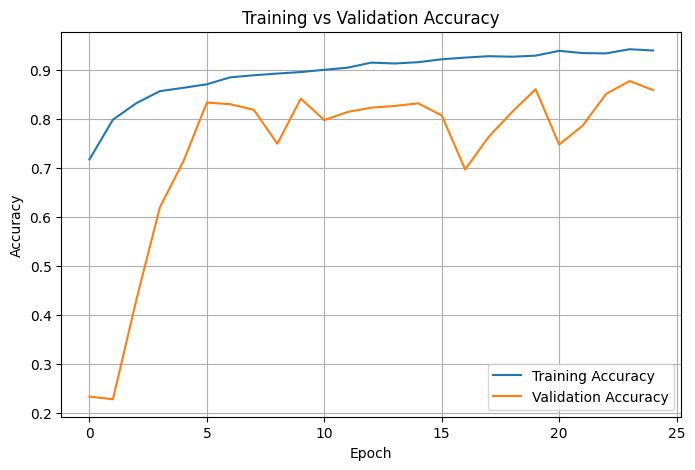

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


##  Confusion Matrix

The confusion matrix visualizes classification performance across tumor classes.


58/58 ━━━━━━━━━━━━━━━━━━━━ 52s 883ms/step


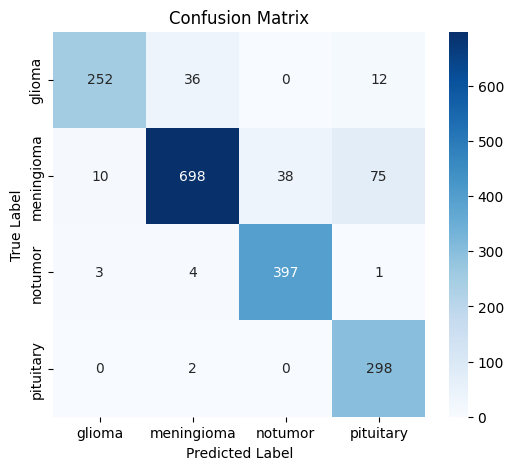

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

y_true = test_ds.classes
y_pred = np.argmax(model.predict(test_ds), axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=train_ds.class_indices.keys(),
    yticklabels=train_ds.class_indices.keys()
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


##  Save & Download Model

The trained model is saved and downloaded for future use.


In [15]:
model.save("brain_tumor_mri_model.h5")


In [16]:
from google.colab import files
files.download("brain_tumor_mri_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>